# Benchmarking Example 

In [1]:
import sys
sys.path.append("..")  # Adds higher directory to python modules path for callback class. 
sys.path.append(r"..\..\..\src\pcgym") # Add local pc-gym files to path using raw string to avoid escape sequence issues.
from pcgym import make_env
from stable_baselines3.common.callbacks import BaseCallback
import csv
import numpy as np
from stable_baselines3 import PPO, DDPG, SAC
import matplotlib.pyplot as plt
from matplotlib import rcParams
import pandas as pd
import os
import sys


Define custom trajectory tracking reward function for comparison to oracle

In [2]:
def sp_track_reward(self,x,u,con):
    Sp_i = 0
    cost = 0 
    R = 0.1
    if not hasattr(self, 'u_prev'):
        self.u_prev = u

    for k in self.env_params["SP"]:
        i = self.model.info()["states"].index(k)
        SP = self.SP[k]
        
        o_space_low = self.env_params["o_space"]["low"][i] 
        o_space_high = self.env_params["o_space"]["high"][i] 

        x_normalized = (x[i] - o_space_low) / (o_space_high - o_space_low)
        setpoint_normalized = (SP - o_space_low) / (o_space_high - o_space_low)

        r_scale = self.env_params.get("r_scale", {})

        cost += (np.sum(x_normalized - setpoint_normalized[self.t]) ** 2) * r_scale.get(k, 1)

        Sp_i += 1
    u_normalized = (u - self.env_params["a_space"]["low"]) / (
        self.env_params["a_space"]["high"] - self.env_params["a_space"]["low"]
    )
    u_prev_norm =  (self.u_prev - self.env_params["a_space"]["low"]) / (
        self.env_params["a_space"]["high"] - self.env_params["a_space"]["low"]
    )
    self.u_prev = u

    # Add the control cost
    cost += np.sum(R * (u_normalized-u_prev_norm)**2)
    r = -cost
    try:
        return r[0]
    except Exception:
        return r

Learning curve callback to aid plotting learning curve

In [3]:
# Callback to write the reward and timestep to a .csv file while training with SB3
class LearningCurveCallback(BaseCallback):
    def __init__(self, verbose=0, log_file="learning_curve.csv"):
        super(LearningCurveCallback, self).__init__(verbose)
        self.episode_rewards = []
        self.log_file = log_file

    def _on_step(self):
        if len(self.model.ep_info_buffer) > 0:
            # Record episode rewards during training
            self.episode_rewards.append(self.model.ep_info_buffer[0].get('r', 0.0))

        return True

    def _on_training_end(self):
        # Save rewards to CSV file
        with open(self.log_file, 'w', newline='') as csvfile:
            writer = csv.writer(csvfile)
            writer.writerow(['Episode', 'Reward'])
            for i, reward in enumerate(self.episode_rewards):
                writer.writerow([i, reward])

Create environment

In [4]:
# Define environment
T = 26
nsteps = 60
training_seed = list(range(42, 72))  # 30 seeds: 42, 43, ..., 71
SP = {
    'Ca': [0.85 for i in range(int(nsteps/3))] + [0.9 for i in range(int(nsteps/3))]+ [0.87 for i in range(int(nsteps/3))],
}

action_space = {
    'low': np.array([295]),
    'high':np.array([302]) 
}

observation_space = {
    'low' : np.array([0.7,300,0.8]),
    'high' : np.array([1,350,0.9])  
}

r_scale = {'Ca':1e3}

# Define reward to be equal to the OCP (i.e the same as the oracle)
env_params = {
    'N': nsteps, 
    'tsim':T, 
    'SP':SP, 
    'o_space' : observation_space, 
    'a_space' : action_space,
    'x0': np.array([0.8,330,0.8]),
    'r_scale': r_scale,
    'model': 'cstr', 
    'normalise_a': True, 
    'normalise_o':True, 
    'noise':True, 
    'integration_method': 'casadi', 
    'noise_percentage':0.001, 
    'custom_reward': sp_track_reward
}

env = make_env(env_params)


Run training using SAC, PPO, and DDPG algorithms

In [10]:
# Global timesteps
nsteps_train = 5e4 
training_reps = 1 # Number of training repetitions (use more for benchmarking, 1 for quick tests)
for r_i in range(training_reps):
    print(f'Training repition:{r_i+1}')
    # Train SAC 
    log_file = f"../pc-gym_paper/train_policies/cstr/learning_curves/SAC_CSTR_LC_rep_{r_i}.csv"
    SAC_CSTR = SAC("MlpPolicy", env, verbose=1, learning_rate=0.01, seed=training_seed[r_i])
    callback = LearningCurveCallback(log_file=log_file)
    SAC_CSTR.learn(nsteps_train, callback=callback)

    # Save SAC Policy 
    SAC_CSTR.save(f'../pc-gym_paper/train_policies/cstr/policies/SAC_CSTR_rep_{r_i}.zip')

    # Train PPO 
    log_file = f"../pc-gym_paper/train_policies/cstr/learning_curves/PPO_CSTR_LC_rep_{r_i}.csv"
    PPO_CSTR = PPO("MlpPolicy", env, verbose=1, learning_rate=0.001, seed=training_seed[r_i])
    callback = LearningCurveCallback(log_file=log_file)
    PPO_CSTR.learn(nsteps_train, callback=callback)

    # Save PPO Policy 
    PPO_CSTR.save(f'../pc-gym_paper/train_policies/cstr/policies/PPO_CSTR_rep_{r_i}.zip')

    # Train DDPG 
    log_file = f'../pc-gym_paper/train_policies/cstr/learning_curves/DDPG_CSTR_LC_rep_{r_i}.csv'
    DDPG_CSTR = DDPG("MlpPolicy", env, verbose=1, learning_rate=0.001, seed=training_seed[r_i])
    callback = LearningCurveCallback(log_file=log_file)
    DDPG_CSTR.learn(nsteps_train, callback=callback)

    # Save DDPG Policy 
    DDPG_CSTR.save(f'../pc-gym_paper/train_policies/cstr/learning_curves/DDPG_CSTR_rep_{r_i}.zip')

Training repition:1
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 59       |
|    ep_rew_mean     | -384     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 92       |
|    time_elapsed    | 2        |
|    total_timesteps | 236      |
| train/             |          |
|    actor_loss      | 6.5      |
|    critic_loss     | 13.7     |
|    ent_coef        | 0.347    |
|    ent_coef_loss   | -0.563   |
|    learning_rate   | 0.01     |
|    n_updates       | 135      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 59       |
|    ep_rew_mean     | -224     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 68       |
|    time_elapsed    | 6        |
|    total_timesteps | 472      |
| 

Plot state and control trajectories

Oracle median cumulative reward: -71.87
SAC optimality gap per step: 0.0085
PPO optimality gap per step: 0.8498
DDPG optimality gap per step: 0.0473
SAC:
  Median Absolute Deviation (MAD): 1.3809
PPO:
  Median Absolute Deviation (MAD): 4.0620
DDPG:
  Median Absolute Deviation (MAD): 2.7247


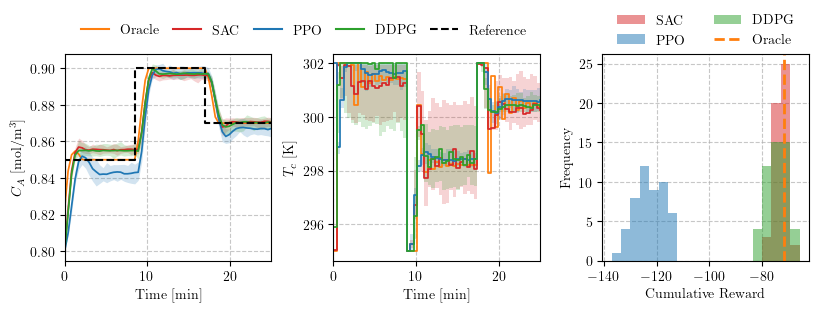

In [ ]:
# Add parent directory to path
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

# Load trained policies
SAC_cstr = SAC.load('../pc-gym_paper/train_policies/cstr/policies/SAC_CSTR.zip')
PPO_cstr = PPO.load('../pc-gym_paper/train_policies/cstr/policies/PPO_CSTR.zip')
DDPG_cstr = DDPG.load('../pc-gym_paper/train_policies/cstr/policies/DDPG_CSTR.zip')

# Visualise policies with the oracle
evaluator, data = env.get_rollouts({'SAC':SAC_cstr,'PPO':PPO_cstr,'DDPG':DDPG_cstr}, reps=50, oracle=True, MPC_params={'N':17})
oracle_r = np.median(data['oracle']["r"].sum(axis=1).flatten())
policies = ['SAC', 'PPO', 'DDPG']
print("="*40)
print(f"Oracle median cumulative reward: {oracle_r:.2f}")
print("="*40)
for policy in policies:
    policy_median = np.median(data[policy]["r"].sum(axis=1).flatten())
    gap = (oracle_r - policy_median) / nsteps
    print(f"{policy}: optimality gap per step: {gap:.4f}")
    print("="*40)

def paper_plot(data):
    # Set up LaTeX rendering
    rcParams['text.usetex'] = True
    rcParams['font.family'] = 'serif'
    rcParams['axes.labelsize'] = 10
    rcParams['xtick.labelsize'] = 10
    rcParams['ytick.labelsize'] = 10
    rcParams['legend.fontsize'] = 10

    t = np.linspace(0, 25, 60)
    
    # A4 width in inches
    a4_width_inches = 8.27
    
    # Calculate height to maintain aspect ratio
    height = a4_width_inches * 0.4  # Adjust this factor as needed
    
    fig, axs = plt.subplots(1, 3, figsize=(a4_width_inches, height))
    plt.subplots_adjust(wspace=0.3, top=0.85, bottom=0.15, left=0.08, right=0.98)

    policies = ['oracle', 'SAC', 'PPO', 'DDPG']
    cols = ['tab:orange', 'tab:red', 'tab:blue', 'tab:green']
    labels = ['Oracle', 'SAC', 'PPO', 'DDPG']

    # Create lines for the legend
    lines = []
    for i, policy in enumerate(policies):
        line, = axs[0].plot([], [], color=cols[i], label=labels[i])
        lines.append(line)
    ref_line, = axs[0].plot([], [], color='black', linestyle='--',  label='Reference')
    lines.append(ref_line)

    # Create legend above the plots
    fig.legend(handles=lines, loc='upper center', bbox_to_anchor=(0.37, 0.94),
                ncol=5, frameon=False, columnspacing=1)

    y_labels = [r'$C_A$ [mol/m$^3$]', r'$T_c$ [K]']
    
    for idx, ax in enumerate(axs):
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.set_axisbelow(True)
        
        if idx == 0:
            for i, policy in enumerate(policies):
                ax.plot(t, np.median(data[policy]['x'][idx,:,:], axis=1), color=cols[i], linewidth=1.25)
                ax.fill_between(t, np.max(data[policy]['x'][idx,:,:], axis=1), 
                                np.min(data[policy]['x'][idx,:,:], axis=1), 
                                alpha=0.2, linewidth=0, color=cols[i])
                
                ax.set_ylabel(y_labels[idx])
                ax.set_xlabel(r'Time [min]')
                ax.set_xlim(0, 25)
            if idx == 0:
                ax.step(t, data['SAC']['x'][2,:,0], color='black', linestyle='--')
        if idx == 1:
            for i, policy in enumerate(policies):
                ax.step(t, np.median(data[policy]['u'][0,:,:], axis=1), color=cols[i], where='post',linewidth=1.25)
                ax.fill_between(t, np.max(data[policy]['u'][0,:,:], axis=1), 
                                np.min(data[policy]['u'][0,:,:], axis=1),
                                step="post", alpha=0.2, linewidth=0, color=cols[i])
                ax.set_ylabel(y_labels[idx])
                ax.set_xlabel(r'Time [min]')
                ax.set_xlim(0, 25)
        if idx == 2:
            # Calculate oracle reward
            oracle_reward = np.median(data['oracle']["r"].sum(axis=1))
            
            # Calculate normalized optimality gap for each policy (for statistics only)
            normalized_gaps = {}
            for policy in policies[1:]:  # Exclude oracle
                gaps = (oracle_reward - data[policy]["r"].sum(axis=1)) 
                normalized_gaps[policy] = gaps.flatten()
            
            # Calculate median absolute deviation and median normalized optimality gap
            mad = {}
            for policy in policies[1:]:
                mad[policy] = np.median(np.abs(data[policy]['r'].sum(axis=1) - np.median(data[policy]['r'].sum(axis=1))))
                print("="*30)
                print(f"{policy}:")
                print(f"  Median Absolute Deviation (MAD): {mad[policy]:.4f}")
                print("="*30)
            # Plot histograms using non-normalized reward values
            all_rewards = np.concatenate([data[policy]["r"].sum(axis=1).flatten() for policy in policies])
            min_reward, max_reward = np.min(all_rewards), np.max(all_rewards)
            bins = np.linspace(min_reward, max_reward, 21)

            for i, policy in enumerate(policies[1:], start=1):
                ax.hist(
                    data[policy]["r"].sum(axis=1).flatten(),
                    bins=bins,
                    color=cols[i],
                    alpha=0.5,
                    label=labels[i],
                    edgecolor='None',
                )
            ax.axvline(x=oracle_reward, color=cols[0], linestyle='--', linewidth=2, label='Oracle')
            ax.set_ylabel('Frequency')
            ax.set_xlabel('Cumulative Reward')
            
            ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.25), ncol=2, frameon=False)
    
    # Adjust the plots to be square and the same size
    for ax in axs:
        ax.set_box_aspect(1)
    plt.show()
paper_plot(data)

Plot learning curves


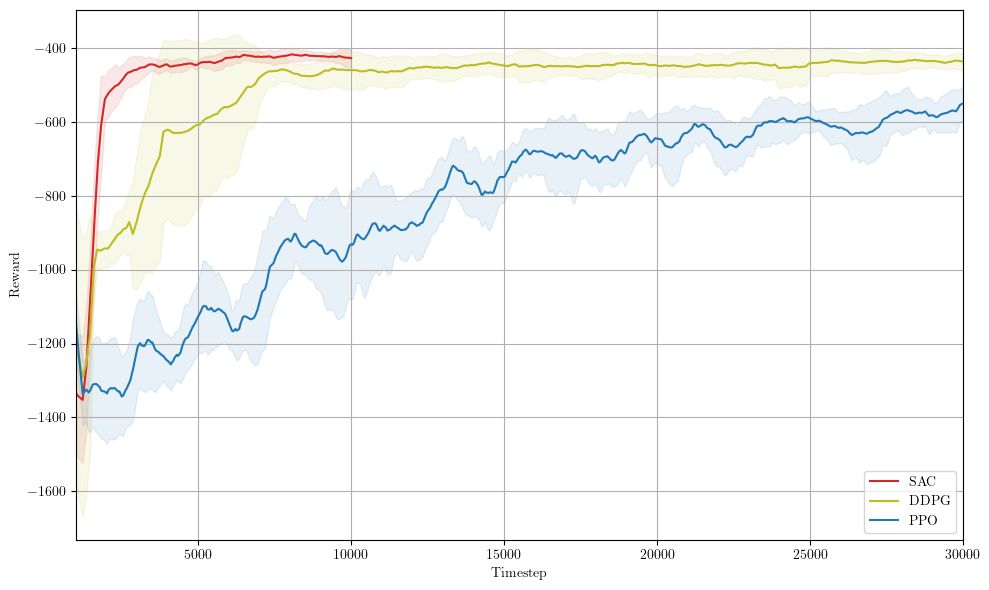

In [ ]:
# Visualise the learning curves
reps = 3
algorithms = ['SAC', 'DDPG', 'PPO']
data = {alg: [] for alg in algorithms}

# Load data
for r_i in range(1,reps):
    for alg in algorithms:
        lc = pd.read_csv(f'../pc-gym_paper/train_policies/cstr/learning_curves/{alg}_CSTR_LC_rep_{r_i}.csv')
        data[alg].append(lc['Reward'])  # Assuming 'reward' is the column name

# Combine and calculate median reward
median_rewards = {}
min_rewards = {}
max_rewards = {}
std_rewards = {}
for alg in algorithms:
    combined_rewards = pd.concat(data[alg], axis=1)
    median_rewards[alg] = combined_rewards.median(axis=1)
    min_rewards[alg] = combined_rewards.min(axis=1)
    max_rewards[alg] = combined_rewards.max(axis=1)
    std_rewards[alg] = combined_rewards.std(axis=1)
window_size = 1000

# Calculate rolling mean for each algorithm
rolling_means = {}
rolling_stds = {}
for alg, rewards in median_rewards.items():
    rolling_means[alg] = rewards.rolling(window=window_size).mean()
    rolling_stds[alg] = std_rewards[alg].rolling(window=window_size).mean()
# Plotting
plt.figure(figsize=(10, 6))

colors = {'SAC': 'tab:red', 'DDPG': 'tab:olive', 'PPO': 'tab:blue'}
for alg, rolling_mean in rolling_means.items():
    plt.plot(rolling_mean.index, rolling_mean, label=alg, color=colors[alg])
    rolling_min = min_rewards[alg].rolling(window=window_size).mean()  
    rolling_max = max_rewards[alg].rolling(window=window_size).mean()
    upper_bound = rolling_mean + rolling_stds[alg]
    lower_bound = rolling_mean - rolling_stds[alg]
    
    plt.fill_between(rolling_mean.index, lower_bound, upper_bound, color=colors[alg], alpha=0.1, label=f'{alg} Std Dev', edgecolor='None')

plt.xlabel('Timestep')
plt.ylabel('Reward')
plt.legend(loc = 'lower right')
plt.xlim(1000,30000)
plt.grid(True)
plt.tight_layout()
plt.show()
